In [1]:
from Annau2023.models import generator, critic
from Annau2023.SRModel import SRModelData, SuperResolver
from Annau2023.RAPSD import compute_rapsd
from Annau2023.progress_bar import progress_bar

import itertools
import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}'
    })


In [2]:
data_path = "/workspace/Annau2023/data/fs_data/"
model_list = {
    "southeast":
        SRModelData(region="southeast", data_path=data_path, sr_model_name="NFS", exp_id="feda42500d2b45549be96f1bf62b0b03"),
    "central":
        SRModelData(region="central", data_path=data_path, sr_model_name="NFS", exp_id="0c5ee480663f4f9eb7200f8879aa1244"),
    "west":
        SRModelData(region="west", data_path=data_path, sr_model_name="NFS", exp_id="db9f0fae83c949eaad5d1176a43dae47"),
}

In [3]:
predictands = ["u10", "v10"]
covariates = ["u10", "v10", "sp", "cape"]
covariates_index = [0, 1, 3, 6]
multipred = {}

for region in model_list:
    print(region)
    model = model_list[region]
    lr, hr = model.load_test()
    G = model.load_generator()
    sr = SuperResolver(region=region, lr=lr.float(), hr=hr.float(), G=G, batch_size=1024)    

    # Process realizations
    baseline_spectrum =  compute_rapsd(sr.super_resolve(), reduce=False)

    covd = {}

    # Iterate through covariates and their indices in the tensors
    for var, cov in zip(covariates_index, covariates):
        mean_rel_error = {key: [] for key in predictands}
        for i in range(25):
            progress_bar(i, 25)
            # Shuffle covariates for fixed var
            random_covariate_shuffle = np.random.randint(0, lr.size(0), lr.size(0))
            lr_c = lr.clone()
            lr_c[:, var, ...] = lr[random_covariate_shuffle, var, ...]

            # Super resolve with shuffled covariates
            sr = SuperResolver(region=model.region, lr=lr_c.float(), hr=hr.float(), G=G, batch_size=1024)

            # Process realizations
            rapsd = compute_rapsd(sr.super_resolve(), reduce=False)
            for pred in predictands:
                rel_error_to_mean = (np.log(rapsd[pred])-np.log(baseline_spectrum[pred]))/np.log(baseline_spectrum[pred])
                mean_rel_error[pred].append(rel_error_to_mean)
        print()
        print(cov)
        covd[cov] = mean_rel_error
    multipred[region] = covd

Progress: [------------------->] 100%
u10
Progress: [------------------->] 100%
v10
Progress: [------------------->] 100%
sp
Progress: [------------------->] 100%
cape
Progress: [------------------->] 100%
u10
Progress: [------------------->] 100%
v10
Progress: [------------------->] 100%
sp
Progress: [------------------->] 100%
cape
Progress: [------------------->] 100%
u10
Progress: [------------------->] 100%
v10
Progress: [------------------->] 100%
sp
Progress: [------------------->] 100%
cape


In [12]:
covariates_name_map = {
    "u10": "$u10$",
    "v10": "$v10$",
    "sp": "Surface Pressure",
    "cape": "CAPE"
}

markers_map  = {
    "u10": "-",
    "v10": "--",
    "sp": "-.",
    "cape": ":"
} 

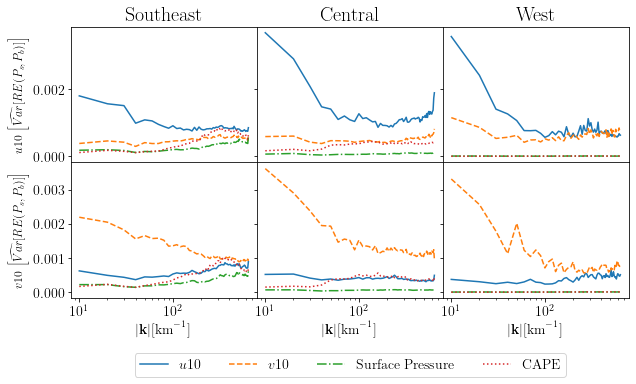

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5), sharey='row', sharex='col')

for region in multipred:
    for covariate in multipred[region]:
        for predictand in multipred[region][covariate]:
            j = list(multipred.keys()).index(region)
            i = list(multipred[region][covariate].keys()).index(predictand)
            ax[i, j].semilogx(
                10*rapsd["k"],
                np.var(np.array(multipred[region][covariate][predictand]), axis=1)[0],
                label=covariates_name_map[covariate], linestyle=markers_map[covariate])

            ax[i, 0].set_ylabel(fr"${predictand}$ $\left[\widehat{{Var}}{{[RE(P_s, P_b)]}}\right]$", fontsize=12)

    ax[-1, j].set_xlabel(r"$|\mathbf{k}| [\textnormal{km}^{-1}]$")
    ax[0, j].set_title(region.capitalize(), fontsize=20)

ax[1, 1].legend(ncol=4, frameon=True, bbox_to_anchor=(0.5023, -0.49), loc='center', fontsize=14)
for a in ax.flat:
    a.set_aspect("auto")

fig.subplots_adjust(wspace=0, hspace=0)